In [1]:
import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
import struct

In [2]:
translate = {'cane': 'dog', 'cavallo': 'horse', 'elefante': 'elephant', 'farfalla': 'butterfly', 'gallina': 'chicken', 'gatto': 'cat', 'mucca': 'cow', 'pecora': 'sheep', 'scoiattolo': 'squirrel', 'dog': 'cane', 'cavallo': 'horse', 'elephant' : 'elefante', 'butterfly': 'farfalla', 'chicken': 'gallina', 'cat': 'gatto', 'cow': 'mucca', 'spider': 'ragno', 'squirrel': 'scoiattolo'}
translate_inv = {v: k for k, v in translate.items()}

folers = os.listdir('raw-img')
categories = {}
for folder in folers:
    if folder == '.DS_Store': continue
    key = (translate_inv | translate)[folder]
    categories[key] = ['raw-img/' + folder + '/' + p for p in os.listdir('raw-img/' + folder)]


In [3]:
def centering_image(img):
    size = [256,256]

    img_size = img.shape[:2]

    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized


In [4]:
total_images = sum(map(len,categories.values()))
total_images

26179

In [6]:
images = []
image_categories_idx_map = []
with tqdm(total=total_images) as pbar:
    for i, (category,file_path) in enumerate([(k,v) for k,vs in categories.items() for v in vs]):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_size = 128
        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*img_size/img.shape[0]),img_size)
        else:
            tile_size = (img_size, int(img.shape[0]*img_size/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:144, 16:144]
        images.append(img)
        image_categories_idx_map.append(category)
        pbar.update(1)

images = np.array(images)

/var/folders/wt/nr12w9r958d0nwkk86zwr9600000gp/T/ipykernel_55519/2785796401.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=total_images) as pbar:


  0%|          | 0/26179 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [7]:
images.shape

(26179, 112, 112, 3)

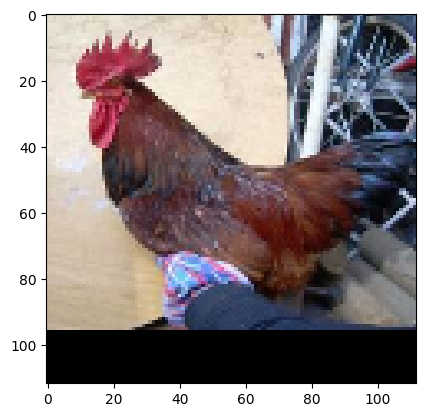

In [8]:
plt.imshow(images[0,:,:,:])

In [9]:
def write_chpl_tensor(a,file):
    shape = a.shape
    shape_size = len(shape)
    file.write(struct.pack('<q', shape_size))
    for s in shape:
        file.write(struct.pack('<q', s))
    # file.write(a.tobytes())
    for x in np.nditer(a):
        file.write(struct.pack('<d', x))


In [10]:
consolidated = {}
for i in range(total_images):
    category = image_categories_idx_map[i]
    img = images[i,:,:,:]
    if category not in consolidated.keys():
        consolidated[category] = []
    if len(consolidated[category]) > 100:
        continue
    consolidated[category].append(img)

consolidated = {k: np.array(v) for k,v in consolidated.items()}
{(k,v.shape) for k,v in consolidated.items()}

{('butterfly', (101, 112, 112, 3)),
 ('cat', (101, 112, 112, 3)),
 ('chicken', (101, 112, 112, 3)),
 ('cow', (101, 112, 112, 3)),
 ('dog', (101, 112, 112, 3)),
 ('elephant', (101, 112, 112, 3)),
 ('horse', (101, 112, 112, 3)),
 ('sheep', (101, 112, 112, 3)),
 ('spider', (101, 112, 112, 3)),
 ('squirrel', (101, 112, 112, 3))}

In [11]:
with tqdm(total=len(consolidated)) as pbar:
    for category, imgs in consolidated.items():
        with open(f'export/{category}.bin', 'wb') as f:
            write_chpl_tensor(imgs,f)
            print(f'export/{category}.bin')
        pbar.update(1)


/var/folders/wt/nr12w9r958d0nwkk86zwr9600000gp/T/ipykernel_55519/1104842063.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(total=len(consolidated)) as pbar:


  0%|          | 0/10 [00:00<?, ?it/s]

export/chicken.bin
export/spider.bin
export/cat.bin
export/butterfly.bin
export/cow.bin
export/horse.bin
export/dog.bin
export/sheep.bin
export/squirrel.bin
export/elephant.bin
